### Modelo Baseline

Como baseline elijo **ResNet18**. Es una red preentrenada, por lo que no es necesario entrenar muchos parámetros. Se entrenó originalmente con **ImageNet** y, en principio, podría dar resultados aceptables como punto de partida.

Además, no es una red neuronal muy grande como la **ResNet34** o **ResNet50**, por lo que resulta más liviana computacionalmente. En caso de obtener buenos resultados con esta (en base a las métricas definidas), se podría considerar pasar a utilizar una red con más capas ocultas.


In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

In [2]:
#!pip install lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from lightning import LightningModule

class LitResNet(LightningModule):
    def __init__(self, num_classes=3):
        super().__init__()
        self.save_hyperparameters()
        resnet = resnet18(weights = ResNet18_Weights.DEFAULT)
        for name, param in resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
            
        in_features = resnet.fc.in_features
        resnet.fc = nn.Identity()
        
        #self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = nn.Sequential(
            resnet,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accuracies.append(acc.item())

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-5)

In [3]:
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping

# early stopping si la validación no mejora después de 5 épocas
early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")

# inicializo el modelo
model = LitResNet(num_classes=3)

# setup del trainer
trainer = Trainer(
    max_epochs=40,
    #callbacks=[early_stop],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    enable_model_summary=False,
    logger=False
)

# entreno
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:658: Checkpoint directory c:\Users\javier\OneDrive\Documents\Repo\Vision-por-Computadora-II\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 39: 100%|██████████| 53/53 [00:11<00:00,  4.42it/s, train_loss=0.338, train_acc=1.000, val_loss=1.270, val_acc=0.731]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 53/53 [00:12<00:00,  4.25it/s, train_loss=0.338, train_acc=1.000, val_loss=1.270, val_acc=0.731]


In [4]:
model.eval()
all_preds = []

for x, _ in test_loader:
    x = x.to(model.device)
    with torch.no_grad():
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())

all_preds = torch.cat(all_preds)

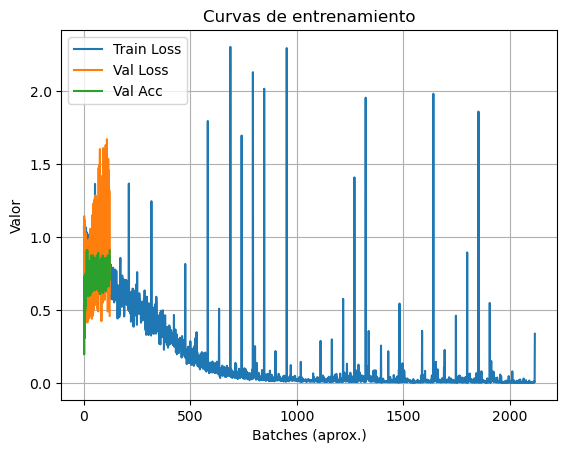

In [5]:
import matplotlib.pyplot as plt

plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Val Loss')
plt.plot(model.val_accuracies, label='Val Acc')
plt.xlabel("Batches (aprox.)")
plt.ylabel("Valor")
plt.title("Curvas de entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
print(model.train_losses)

[1.0687377452850342, 1.1115596294403076, 1.1016027927398682, 1.117979884147644, 1.082993507385254, 1.0407379865646362, 1.0711058378219604, 1.0196640491485596, 1.0207420587539673, 1.066678524017334, 0.9650936722755432, 1.0309665203094482, 0.9870299100875854, 1.0352188348770142, 1.0244712829589844, 1.0253324508666992, 1.0227078199386597, 1.002935767173767, 0.9855305552482605, 0.9545559883117676, 0.934421956539154, 0.94618159532547, 1.003844141960144, 0.9547190070152283, 1.0154329538345337, 0.9884394407272339, 0.9361540079116821, 0.8978371024131775, 0.9208990335464478, 0.9212621450424194, 0.958885669708252, 0.8833537697792053, 0.886183500289917, 0.8988157510757446, 0.927629292011261, 0.8745782971382141, 0.9179657101631165, 0.8806397318840027, 0.9183796048164368, 0.7994336485862732, 0.8785400390625, 0.7626599669456482, 0.8526185750961304, 0.8540146350860596, 0.8093006610870361, 0.8795424699783325, 0.8687077760696411, 0.8411422967910767, 0.859294056892395, 0.8951828479766846, 0.813177764415

In [7]:
from sklearn.metrics import recall_score, f1_score

def compute_enfermo_vs_sano_recall(y_true, y_pred):
    y_true_bin = [0 if x == 'Normal' else 1 for x in y_true]
    y_pred_bin = [0 if x == 'Normal' else 1 for x in y_pred]
    return recall_score(y_true_bin, y_pred_bin)

def compute_enfermedades_f1(y_true, y_pred):
    y_true_sub = [x for x, y in zip(y_true, y_pred) if x != 'Normal']
    y_pred_sub = [y for x, y in zip(y_true, y_pred) if x != 'Normal']
    return f1_score(y_true_sub, y_pred_sub, average='macro') 

def diagnostic_score(y_true, y_pred, alpha=0.7, beta=0.3):
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1_enf = compute_enfermedades_f1(y_true, y_pred)
    return alpha * recall + beta * f1_enf